# Goal:

In this assignment, you will implement the self-supervised contrastive learning algorithm, [SimCLR](https://arxiv.org/abs/2002.05709), using PyTorch. You will use the STL-10 dataset for this assignment.

You need to compete the `Net` class definition, the `SimCLRDataset` dataset class definition and the SimCLR loss in the `Trainer` class. You need to run the training loop, save the best training model and evaluate using the `linear probe` classfication task. Since we don't have enough GPU resources and contrastive learning algorithm like SimCLR usually needs around `1000` epoches to train (we only have `70` epoches), you may not get the best performance. Thus, as for the performance side, as long as you see the loss is decreasing (to around 7.4 at `70` epoch) and the accuracy is increasing, you are good to go.

Grade:

- **Fill the Net class definition (5 points).**
- **Fill the SimCLRDataset dataset class definition (10 points).**
- **Fill the SimCLR loss in the Trainer class (20 points).**
- **Record the training loss within 70 epochs, the lower the better (5 points).**
- **Record the linear probe accuracy, the higher the better (5 points).**
- **Write a report including:**
  - **How you select data augmentation (transform) in the transform pool.**
  - **How you implement the SimCLR loss and explain why your SimCLR loss is computationally efficient and equivalent to the loss function in the paper.**
  - **Include the training loss curve and the downstream accuracy (15 points). Note that the logging logic is not provided, please implement them before you start training.**
---
Please DO NOT change the config provided. Only change the given code if you are confident that the change is necessary. It is recommended that you **use CPU session to debug** when GPU is not necessary since Colab only gives 12 hrs of free GPU access at a time. If you use up the GPU resource, you may consider to use Kaggle GPU resource. Thank you and good luck!

# Self-supervised learning: SimCLR

Self-supervised learning

1.   Design an auxiliary task.
2.   Train the base network on the auxiliary task.
3.   Evaluate on the down-stream task: Train a new decoder based on the trained encoder.

Specifically, as one of the most successful self-supervised learning algorithm, SimCLR, a contrastive learning algorithm is what we focus today. Below, we are going to implement SimCLR as an example of self-supervised learning.


<img src="https://camo.githubusercontent.com/35af3432fbe91c56a934b5ee58931b4848ab35043830c9dd6f08fa41e6eadbe7/68747470733a2f2f312e62702e626c6f6773706f742e636f6d2f2d2d764834504b704539596f2f586f3461324259657276492f414141414141414146704d2f766146447750584f79416f6b4143385868383532447a4f67457332324e68625877434c63424741735948512f73313630302f696d616765342e676966" width="650" height="650">

In [ ]:
# Config
# Since, we are using jupyter notebook, we use easydict to micic argparse. Feel free to use other format of config
from easydict import EasyDict
import torch.nn as nn
from tqdm import tqdm
import torch

config = {
    'dataset_name': 'stl10',
    'workers': 1,
    'epochs': 70,
    'batch_size': 3072,
    'lr': 0.0003,
    'weight_decay': 1e-4,
    'seed': 4242,
    'fp16_precision': True,
    'out_dim': 128,
    'temperature': 0.5,
    'n_views': 2,
    'device': "cuda" if torch.cuda.is_available() else "cpu",
}
args = EasyDict(config)

We are going to use [STL-10 dataset](https://cs.stanford.edu/~acoates/stl10/).

<img src="https://cs.stanford.edu/~acoates/stl10/images.png" width="450" height="450">

Overview

*   10 classes: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck.
*   Images are **96x96** pixels, color.
*   500 training images (10 pre-defined folds), 800 test images per class.
*   100000 unlabeled images for unsupervised learning. These examples are extracted from a similar but broader distribution of images. For instance, it contains other types of animals (bears, rabbits, etc.) and vehicles (trains, buses, etc.) in addition to the ones in the labeled set.
*   Images were acquired from labeled examples on ImageNet.


## Preparation

Define a ResNet-18 and an additional MLP layer as the model training in the auxiliary task.

In [ ]:
import torchvision.models as models

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.basemodel = models.resnet18(pretrained=False, num_classes=args.out_dim)
        self.fc_in_features = self.basemodel.fc.in_features # number of input features for the fc layer
        self.backup_fc = None
        # ToDO: define an MLP layer to insert between the last layer and the rest of the model
        #self.fc_out_features = self.basemodel.fc.out_features
        self.mlp = nn.Sequential(
            nn.Linear(self.fc_in_features, self.fc_in_features),
            nn.ReLU()
        )
        self.basemodel.fc = nn.Sequential(
            self.mlp,
            self.basemodel.fc
        )

    def forward(self, x):
        # ToDo: implement the forward logic
        x = self.basemodel(x)
        return x

    def linear_probe(self):
        self.freeze_basemodel_encoder()
        self.backup_fc = self.basemodel.fc  # Backup the last Linear layer
        # ToDo: implement the linear probe for your downstream task. A linear prob is just a linear layer (not MLP, no activation layer included) after the learned encoder.
        # 10 classes for downstream class
        self.basemodel.fc = nn.Linear(self.fc_in_features, 10)

    def restore_backbone(self):
        self.basemodel.fc = self.backup_fc
        self.backup_fc = None

    def freeze_basemodel_encoder(self):
        # do not freeze the self.basemodel.fc weights
        for name, param in self.basemodel.named_parameters():
            if 'fc' not in name:
                param.requires_grad = False

# Step 1: Design the auxiliary task.
## construct the dataset

In [ ]:
from torchvision import transforms, datasets

class View_sampler(object):
    """This class randomly sample two transforms from the list of transforms for the SimCLR to use. It is used in the SimCLRDataset.get_dataset."""

    def __init__(self, transforms, n_views=2):
        self.transforms = transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self.transforms(x) for i in range(self.n_views)]


class SimCLRDataset:
    def __init__(self, root_folder="./datasets"):
        self.root_folder = root_folder

    @staticmethod
    def transforms_pool(size):
        # ToDo
        data_transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomResizedCrop(size=size), # 96
            transforms.RandomApply([
                transforms.ColorJitter(brightness=0.5,
                                       contrast=0.5,
                                       saturation=0.5,
                                       hue=0.1)
                ], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.GaussianBlur(kernel_size=9),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
            ])
        # for example, you can use RandomResizedCrop, RandomHorizontalFlip, ColorJitter, RandomGrayscale, GaussianBlur, ToTensor (compulsory), Normalize (), etc.
        return data_transforms

    def get_dataset(self):
        dataset_fn = lambda: datasets.STL10(self.root_folder, split='unlabeled', transform=View_sampler(self.transforms_pool(96), 2), download=True)
        return dataset_fn()

## Define dataloader, optimizer and scheduler

What is a scheduler?

A scheduler helps in optimizing the convergence, avoiding local minima, and potentially improving the model's performance on the task at hand. The learning rate is one of the most important hyperparameters for training neural networks, and finding an appropriate learning rate schedule can be crucial for your model's success.

<img src="https://miro.medium.com/v2/resize:fit:4800/format:webp/1*qe6nYlH8zsmUdScyHMhRCQ.png" width="1200" height="450">

Read more here: https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

In [ ]:
from torch.utils.data import DataLoader
model = Net()
# Move the model to the device (CPU or GPU)
model.to(args.device)
dataset = SimCLRDataset()
train_dataset = dataset.get_dataset()
# ToDo, define dataloader based on the train_dataset with drop_last=True
dataloader = DataLoader(train_dataset, batch_size=args.batch_size,
                        shuffle=True, num_workers=args.workers, drop_last=True)
# ToDo, define an optimizer with args.lr as the learning rate and args.weight_decay as the weight_decay
optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
# ToDo, define an lr_scheduler CosineAnnealingLR for the optimizer
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Files already downloaded and verified


# Define the trainer


Automatic Mixed Precision (AMP) is a technique that aims to improve the speed and efficiency of training deep neural networks by leveraging mixed-precision training.

**Introduction to AMP**

AMP allows neural network training to use both single-precision (FP32) and half-precision (FP16) floating point arithmetic simultaneously. The main idea behind AMP is to perform certain operations in FP16 to exploit the faster arithmetic and reduced memory usage of lower-precision computing, while maintaining the critical parts of the computation in FP32 to ensure model accuracy and stability.

**Why We Cannot Always Use FP16**



*   **Numerical Stability**: FP16 has a smaller dynamic range and lower precision compared to FP32. This limitation can lead to numerical instability, such as underflows and overflows, particularly during operations that involve small gradient values or require high numerical precision. This can adversely affect the convergence and accuracy of the trained model.
*   **Selective Precision Requirements**: Certain operations and layers within neural networks are more sensitive to precision than others. For example, weight updates in optimizers might require FP32 to maintain accuracy over time. AMP strategies, therefore, involve selectively applying FP16 to parts of the computation where it can be beneficial without undermining the overall training process.

Below, we present how to include AMP logic in standard torch training procedure.

Before including AMP:
```python
for batch in data_loader:
    # Forward pass
    inputs, targets = batch
    outputs = model(inputs)
    loss = loss_fn(outputs, targets)

    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
```

After including AMP:
```python
from torch.cuda.amp import GradScaler, autocast

scaler = GradScaler()

for batch in data_loader:
    inputs, targets = batch[0].cuda(), batch[1].cuda()

    # Forward pass
    with autocast():
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

    # Backward pass and optimize
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
```


Read more here: https://pytorch.org/docs/stable/amp.html

## Implement loss function in the Trainer
The algorithm of SimCLR Loss function is as follows:
$$
\begin{aligned}
&\text{for all } i \in \{1, \ldots, 2N\} \text{ and } j \in \{1, \ldots, 2N\} \text{ do} \\
&\quad s_{i,j} = \frac{z_i^\top z_j}{\|z_i\|\|z_j\|} \quad \text{# pairwise similarity} \\
&\text{end for} \\
&\text{define } \ell(i,j) \text{ as } \ell(i,j) = -\log \left( \frac{\exp(s_{i,j} / \tau)}{\sum_{k=1}^{2N} \mathbb{1}_{[k \neq j]} \exp(s_{i,k} / \tau)} \right) \\
&\mathcal{L} = \frac{1}{2N} \sum_{k=1}^{N} \left[\ell(2k-1, 2k) + \ell(2k, 2k-1)\right] \\
&\text{update networks } f \text{ and } g \text{ to minimize } \mathcal{L}
\end{aligned}
$$

Please fill the blanks in the loss function below. Hint: implement mask to avoid including self-self similarity, and postive pairs and negative pairs.

In [ ]:
import torch
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast


class Trainer():
    def __init__(self, *args, **kwargs):
        self.args = kwargs['args']
        self.model = kwargs['model'].to(self.args.device)
        self.optimizer = kwargs['optimizer']
        self.scheduler = kwargs['scheduler']
        self.criterion = torch.nn.CrossEntropyLoss().to(self.args.device)
        self.train_losses = []

    def loss(self, features):
        # input features is a torch tensor with shape of (2*batch_size, out_dim)
        # The positive pairs are (features[i] and features[i+batch_size]) for all i
        # TODO: implement the loss function
        batch_size = features.size(0)//2

        features_normalized = F.normalize(features, dim=1)
        sim_matrix = torch.matmul(features_normalized, features_normalized.T)

        # Positive pairs
        # Similarity matrix values for positive pairs in 1st order
        postive_pairs_1 = torch.diag(sim_matrix, batch_size)
        # Similarity matrix for positive pairs in 2nd order
        postive_pairs_2 = torch.diag(sim_matrix, -batch_size)
        # All positive pairs
        positive_pairs = torch.cat([postive_pairs_1, postive_pairs_2], dim=0)
        nominator = torch.exp(positive_pairs/self.args.temperature)

        # Calculation of the denominator: positive and negative pairs
        # Mask: inverse of identity matrix
        mask = (~torch.eye(batch_size*2, batch_size*2, dtype=bool, device=features.device)).float()
        denominator = mask * torch.exp(sim_matrix/self.args.temperature)

        # Sum of losses
        all_losses = -torch.log(nominator / torch.sum(denominator, dim=1))
        loss = torch.sum(all_losses)/(2*batch_size)
        return loss

    def train(self, dataloader):
        # implement GradScaler if AMP
        best_loss = 1e4
        scaler = GradScaler(enabled=self.args.fp16_precision)
        for epoch in range(self.args.epochs):
            epoch_loss = 0
            for images, _ in tqdm(dataloader):
                images = torch.cat(images, dim=0)
                images = images.to(self.args.device)

                with autocast(enabled=self.args.fp16_precision):
                    features = self.model(images)
                    loss = self.loss(features)

                # features = self.model(images)
                # loss = self.loss(features)
                self.optimizer.zero_grad()

                scaler.scale(loss).backward()
                scaler.step(self.optimizer)
                scaler.update()

                # loss.backward()
                # self.optimizer.step()
                self.scheduler.step()

                # Accumulation of the loss for the epoch
                epoch_loss += loss.item()

            # Averaging loss over batch size for an epoch
            epoch_loss /= len(dataloader.dataset)
            self.train_losses.append(epoch_loss)

            # warmup for the first 10 epochs
            if epoch >= 10:
                self.scheduler.step()
            if epoch % 10 == 0 and epoch != 0:
                self.save_model(self.model, f"model_{epoch}.pth")
            # save the lowest loss model
            # feel free to implement your own logic to save the best model
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                self.save_model(self.model, f"best_model.pth")
            print(f"Epoch {epoch}, Loss {loss.item()}, Epoch-loss {epoch_loss}")
            self.save_training_losses(self.train_losses, "training_losses.pth")
            self.save_training_losses(self.train_losses, "training_losses.txt")

        return self.model

    def save_model(self, model, path):
        torch.save(model.state_dict(), path)

    def save_training_losses(self, loss_list, path):
        torch.save(loss_list, path)

# Step 2: Train the base network on the auxiliary task for 70 epoch and save the best model you have for evaluation.

Check if the training loss drops over time and try to capture other possible bug using logging tools. Each epoch should take around 7 minutes. The loss should be expected to around 7.4.

In [ ]:
trainer = Trainer(args=args, model=model, optimizer=optimizer, scheduler=lr_scheduler)
trainer.train(dataloader)

  0%|          | 0/32 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 32/32 [15:25<00:00, 28.80s/it]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 32/32 [15:25<00:00, 28.91s/it]


Epoch 0, Loss 8.02319622039795, Epoch-loss 0.0026546521377563475


Net(
  (basemodel): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

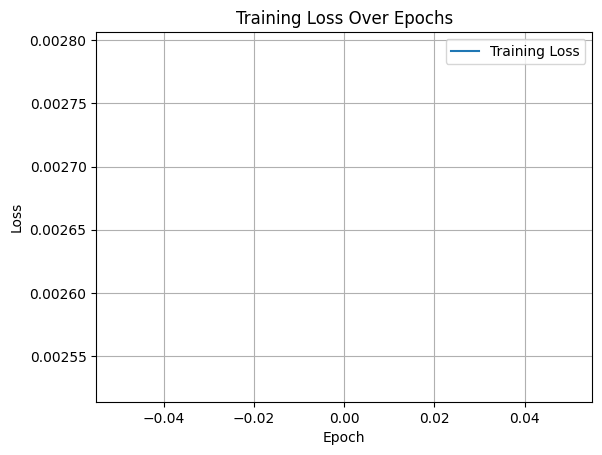

In [ ]:
import matplotlib.pyplot as plt

def plot_losses(losses):
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.grid(True)

    # Save the plot as an image
    plt.savefig('images/training_losses.png')
    plt.show()

training_losses = trainer.train_losses
plot_losses(training_losses)

# Step 3: Evaluate on the down-stream task: Train a new MLP decoder based on the trained encoder.

This finetune process should be way faster than the previous one. The expected Top-1 accuracy should be around 57% and the Top-5 accuracy should be around 97%. Getting this results is normal because linear prob is just a projection layer usually recognized as not having representation ability. To achieve the performance mentioned in the paper, we need larger dataset and more powerful GPU and longer time (about 1000 epoches during the pretraining stage).

In [ ]:
class linear_prob_Trainer:
    def __init__(self, *args, **kwargs):
        self.args = kwargs["args"]
        self.model = kwargs["model"].to(self.args.device)
        self.optimizer = kwargs["optimizer"]
        self.criterion = torch.nn.CrossEntropyLoss().to(self.args.device)
        self.top1_train_accs = []
        self.top5_train_accs = []
        self.train_dataset = datasets.STL10(
            "./data", split="train", download=True, transform=transforms.ToTensor()
        )

        self.train_loader = torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.args.batch_size,
            num_workers=1,
            drop_last=False,
        )

        self.test_dataset = datasets.STL10(
            "./data", split="test", download=True, transform=transforms.ToTensor()
        )

        self.test_loader = torch.utils.data.DataLoader(
            self.test_dataset,
            batch_size=self.args.batch_size,
            num_workers=1,
            drop_last=False,
        )

    def accuracy(self, output, target, topk=(1,)):
        with torch.no_grad():
            maxk = max(topk)
            batch_size = target.size(0)

            _, pred = output.topk(maxk, 1, True, True)
            pred = pred.t()
            correct = pred.eq(target.view(1, -1).expand_as(pred))

            res = []
            for k in topk:
                correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
                res.append(correct_k.mul_(100.0 / batch_size))
            return res

    def train(self, dataloader):
        for epoch in range(100):
            top1_train_accuracy = 0
            top5_train_accuracy = 0
            for images, labels in tqdm(dataloader):
                images, labels = images.to(self.args.device), labels.to(
                    self.args.device
                )
                logits = self.model(images)
                loss = self.criterion(logits, labels)
                top1 = self.accuracy(logits, labels, topk=(1,))
                top1_train_accuracy += top1[0]
                print(top1[0])
                top5 = self.accuracy(logits, labels, topk=(5,))
                top5_train_accuracy += top5[0]

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                print(
                    f"Epoch: {epoch}, Loss: {loss.item()}",
                    "Top1 Train Accuracy: ",
                    top1_train_accuracy.item() / len(dataloader),
                )

            # Calculate average accuracies for the epoch
            avg_top1_train_acc = top1_train_accuracy.item()/len(dataloader.dataset)
            avg_top5_train_acc = top5_train_accuracy.item()/len(dataloader.dataset)
            # Append the average accuracies for logging
            self.top1_train_accs.append(avg_top1_train_acc)
            self.top5_train_accs.append(avg_top5_train_acc)
            self.save_training_accs(self.top1_train_accs, "training_top1_accs.pth")
            self.save_training_accs(self.top1_train_accs, "training_top1_accs.txt")
            self.save_training_accs(self.top5_train_accs, "training_top5_accs.pth")
            self.save_training_accs(self.top5_train_accs, "training_top5_accs.txt")

        return self.model

    def save_training_accs(self, acc_list, path):
        torch.save(acc_list, path)

    def save_test_acc(self, acc, path):
        torch.save(acc, path)

    def test(self, dataloader):
        with torch.no_grad():
            model.eval()
            top1_test_accuracy = 0
            top5_test_accuracy = 0
            for images, labels in tqdm(dataloader):
                images, labels = images.to(self.args.device), labels.to(
                    self.args.device
                )
                logits = self.model(images)
                top1 = self.accuracy(logits, labels, topk=(1,))
                top1_test_accuracy += top1[0]
                top5 = self.accuracy(logits, labels, topk=(5,))
                top5_test_accuracy += top5[0]
            print("Top1 Test Accuracy: ", top1_test_accuracy.item() / len(dataloader))
            print("Top5 Test Accuracy: ", top5_test_accuracy.item() / len(dataloader))

            # Calculate average accuracies for the images
            avg_top1_test_acc = top1_test_accuracy.item()/len(dataloader.dataset)
            avg_top5_test_acc = top5_test_accuracy.item()/len(dataloader.dataset)

            self.save_test_acc(avg_top1_test_acc, "test_top1_acc.pth")
            self.save_test_acc(avg_top1_test_acc, "test_top1_acc.txt")
            self.save_test_acc(avg_top5_test_acc, "test_top5_acc.pth")
            self.save_test_acc(avg_top5_test_acc, "test_top5_acc.txt")

            return avg_top1_test_acc, avg_top5_test_acc

# load your model here if you need to resume
model.linear_probe()
linear_probe_optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
linear_prob_trainer = linear_prob_Trainer(args=args, model=model, optimizer=linear_probe_optimizer)
model = linear_prob_trainer.train(linear_prob_trainer.train_loader)
avg_top1_test_acc, avg_top5_test_acc = linear_prob_trainer.test(linear_prob_trainer.test_loader)
print("Top 1 accuracy on test set: ", avg_top1_test_acc)
print("Top 5 accuracy on test set: ", avg_top5_test_acc)

Files already downloaded and verified
Files already downloaded and verified


 50%|█████     | 1/2 [00:03<00:03,  3.04s/it]

tensor([14.7786], device='cuda:0')
Epoch: 0, Loss: 2.308171510696411 Top1 Train Accuracy:  7.389322757720947


100%|██████████| 2/2 [00:04<00:00,  2.07s/it]


tensor([17.4274], device='cuda:0')
Epoch: 0, Loss: 2.266273021697998 Top1 Train Accuracy:  16.103015899658203


 50%|█████     | 1/2 [00:02<00:02,  2.51s/it]

tensor([18.9779], device='cuda:0')
Epoch: 1, Loss: 2.224827527999878 Top1 Train Accuracy:  9.488931655883789


100%|██████████| 2/2 [00:03<00:00,  1.74s/it]


tensor([19.7095], device='cuda:0')
Epoch: 1, Loss: 2.1916584968566895 Top1 Train Accuracy:  19.343704223632812


 50%|█████     | 1/2 [00:02<00:02,  2.38s/it]

tensor([21.2565], device='cuda:0')
Epoch: 2, Loss: 2.159437417984009 Top1 Train Accuracy:  10.628254890441895


100%|██████████| 2/2 [00:03<00:00,  1.67s/it]


tensor([22.2510], device='cuda:0')
Epoch: 2, Loss: 2.1308398246765137 Top1 Train Accuracy:  21.753772735595703


 50%|█████     | 1/2 [00:02<00:02,  2.51s/it]

tensor([23.0143], device='cuda:0')
Epoch: 3, Loss: 2.103731155395508 Top1 Train Accuracy:  11.507161140441895


100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


tensor([23.7552], device='cuda:0')
Epoch: 3, Loss: 2.079369068145752 Top1 Train Accuracy:  23.384754180908203


 50%|█████     | 1/2 [00:02<00:02,  2.57s/it]

tensor([24.2839], device='cuda:0')
Epoch: 4, Loss: 2.0562334060668945 Top1 Train Accuracy:  12.141926765441895


100%|██████████| 2/2 [00:03<00:00,  1.75s/it]


tensor([24.8444], device='cuda:0')
Epoch: 4, Loss: 2.036384105682373 Top1 Train Accuracy:  24.564125061035156


100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Top1 Test Accuracy:  24.090413411458332
Top5 Test Accuracy:  79.9254659016927
Top 1 accuracy on test set:  0.009033905029296876
Top 5 accuracy on test set:  0.029972049713134767


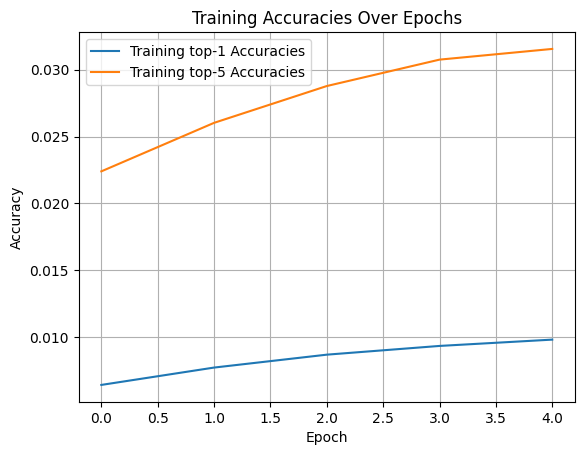

In [ ]:
def plot_accs(accs1, accs2):
    plt.plot(accs1, label='Training top-1 Accuracies')
    plt.plot(accs2, label='Training top-5 Accuracies')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracies Over Epochs')
    plt.legend()
    plt.grid(True)

    # Save the plot as an image
    plt.savefig('images/training_accuracies.png')
    plt.show()

top1_training_accs = linear_prob_trainer.top1_train_accs
top5_training_accs = linear_prob_trainer.top5_train_accs

plot_accs(top1_training_accs, top5_training_accs)